### Task 6 for IT-Jim Summer Internship 2020.<br>
More about IT-Jim: https://www.it-jim.com

In [15]:
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt

In [16]:
seed = 24
batch_size = 32
num_classes = 16

In [17]:
classes = os.listdir('../input/miniimagenet-itjim-internship-2020-task6/dataset/train')

First we will build a basic fully-connected model which will just flatten an output and feedforward it through a few linear layers.

In [18]:
shed = K.optimizers.schedules.ExponentialDecay(
    0.01, 100000, decay_rate=0.95)
opt = K.optimizers.Adam(learning_rate=shed)

In [19]:
def build_fc_model(channels=3, img_size=84):
    
    inputs = K.layers.Input((img_size, img_size, channels))
    flat = K.layers.Flatten()(inputs)
    first_dense = K.layers.Dense(
        channels*img_size**2)(flat)
    first_dense = K.layers.LeakyReLU()(first_dense)
    drop = K.layers.Dropout(0.3)(first_dense)
    
    second_dense = K.layers.Dense(img_size*5)(drop)
    second_dense = K.layers.LeakyReLU()(second_dense)
    last_dense = K.layers.Dense(img_size*2)(second_dense)
    last_dense = K.layers.LeakyReLU()(last_dense)
    outputs = K.layers.Dense(num_classes, activation='softmax')(last_dense)

    model = K.models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=opt,
                    loss='categorical_crossentropy',
                    metrics=['categorical_accuracy', 
                             K.metrics.Recall(), 
                             K.metrics.Precision()])

    return model

Next I will try to build as close replica of CNN model as I build in pytorch and a Mini-Resnet. One issue though arisen: I think I built residual block correctly but I am not sure (and accuracy metrics suggest either I am wrong somewhere or in pytorch version I did deep-tunning(TM) ). Nevertheless, I do understand what I do in pytorch while in keras many things are hidden (or require even more explicit rewriting).

In [20]:
def residual_block(x):
    filters = x.shape[-1]
    y = K.layers.Conv2D(filters, (3,3), padding="same")(x)
    l_relu = K.layers.LeakyReLU()(y)
    bn = K.layers.BatchNormalization()(l_relu)
    y = K.layers.Conv2D(filters, (3, 3), padding="same")(bn)
    
    out = K.layers.Add()([x, y])
    out = K.layers.BatchNormalization()(out)
    out = K.layers.Conv2D(filters, (3, 3), padding="same")(out)
    return out

def build_cnn_model(channels=3, img_size=84):
    
    inputs = K.layers.Input((img_size, img_size, channels))
    # inputs = K.layers.Lambda(lambda x: x / 255)(inputs)

    conv1 = K.layers.Conv2D(channels, (3, 3), padding='same')(inputs)
    conv1 = K.layers.LeakyReLU()(conv1)
    conv1 = K.layers.Dropout(0.3)(conv1)
    conv2 = K.layers.Conv2D(channels*5, (3, 3), padding='same')(conv1)
    conv2 = K.layers.LeakyReLU()(conv2)
    pool1 = K.layers.MaxPooling2D((2, 2))(conv2)
    
    bottleneck = K.layers.Conv2D(channels, (3, 3), padding='same')(pool1)
    bottleneck = K.layers.LeakyReLU()(bottleneck)
    bottleneck = K.layers.Dropout(0.3)(bottleneck)
    conv_last = K.layers.Conv2D(1, (3, 3), padding='same')(bottleneck)
    conv_last = K.layers.LeakyReLU()(conv_last)
    pool2 = K.layers.MaxPooling2D((2, 2))(conv_last)
    pool2 = K.layers.Flatten()(pool2)
    outputs = K.layers.Dense(num_classes, activation='softmax')(pool2)
    
    model = K.models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=opt,
                    loss='categorical_crossentropy',
                    metrics=['categorical_accuracy', K.metrics.Recall(), K.metrics.Precision()])
                  # metrics=['accuracy'])

    return model

def build_resnet_model(channels=3, img_size=84):
    
    inputs = K.layers.Input((img_size, img_size, channels))
    # inputs = K.layers.Lambda(lambda x: x / 255)(inputs)

    conv1 = K.layers.Conv2D(channels, (3, 3), padding='same')(inputs)
    conv1 = K.layers.LeakyReLU()(conv1)
    conv1 = K.layers.Dropout(0.3)(conv1)
    res = residual_block(conv1)
    conv2 = K.layers.Conv2D(channels, (3, 3), padding='same')(res)
    conv2 = K.layers.LeakyReLU()(conv2)
    pool = K.layers.MaxPooling2D((2, 2))(conv2)
    pool = K.layers.Flatten()(pool)
    outputs = K.layers.Dense(num_classes, activation='softmax')(pool)
    
    model = K.models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=opt,
                    loss='categorical_crossentropy',
                    metrics=['categorical_accuracy', K.metrics.Recall(), K.metrics.Precision()])
                  # metrics=['accuracy'])

    return model

In [21]:
train_set = K.preprocessing.image_dataset_from_directory(
    '../input/miniimagenet-itjim-internship-2020-task6/dataset/train',
    color_mode="rgb", batch_size=batch_size, image_size=(84, 84),
    shuffle=True, seed=seed, label_mode='categorical')

val_set = K.preprocessing.image_dataset_from_directory(
    '../input/miniimagenet-itjim-internship-2020-task6/dataset/val',
    color_mode="rgb", batch_size=batch_size, image_size=(84, 84),
    shuffle=True, seed=seed, label_mode='categorical')

test_set = K.preprocessing.image_dataset_from_directory(
    '../input/miniimagenet-itjim-internship-2020-task6/dataset/test',
    color_mode="rgb", batch_size=batch_size, image_size=(84, 84),
    shuffle=True, seed=seed, label_mode='categorical')

Found 1120 files belonging to 16 classes.
Found 240 files belonging to 16 classes.
Found 240 files belonging to 16 classes.


In [22]:
def show_sample(dataset, grid=(4, 4)):
    fig, ax = plt.subplots(grid[0], grid[1])
    i = j = 0
    for batch in dataset.take(1):

        for x in batch:
            for c, img in enumerate(x):
                #print(img.shape)
                ax[i][j].imshow(np.uint8(img))
                ax[i][j].set_title('{}'.format(
                    classes[c]), fontsize=11)
                ax[i][j].axis('off')
                j += 1
                if j == grid[0]:
                    j = 0
                    i += 1
                if i == grid[1]:
                    break
            plt.tight_layout()
            plt.show()
            break

In [23]:
train_gen = K.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True, rescale=1/255)
train_gen = train_gen.flow_from_directory(
        '../input/miniimagenet-itjim-internship-2020-task6/dataset/train',
        target_size=(84, 84),
        batch_size=batch_size,
        class_mode='categorical')

val_gen = K.preprocessing.image.ImageDataGenerator(
    rescale=1/255)
val_gen = val_gen.flow_from_directory(
        '../input/miniimagenet-itjim-internship-2020-task6/dataset/val',
        target_size=(84, 84),
        batch_size=batch_size,
        class_mode='categorical')

test_gen = K.preprocessing.image.ImageDataGenerator(
    rescale=1/255)
test_gen = test_gen.flow_from_directory(
        '../input/miniimagenet-itjim-internship-2020-task6/dataset/test',
        target_size=(84, 84),
        batch_size=batch_size,
        class_mode='categorical')

Found 1120 images belonging to 16 classes.
Found 240 images belonging to 16 classes.
Found 240 images belonging to 16 classes.


Training FC model

In [24]:
epochs = 10

In [25]:
best_chpt = K.callbacks.ModelCheckpoint(filepath='{epoch}_{model}_best.ckpt',
                                        monitor='val_loss',
                                        mode='max',
                                        save_best_only=True, 
                                        save_weights_only=True,
                                       verbose=1)
runtime_chpt = K.callbacks.ModelCheckpoint(filepath='{epoch}_{model}_last.ckpt',
                                           monitor="val_loss",
                                           save_weights_only=True,
                                           save_freq=int(batch_size*5))

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 2.7730 - categorical_accuracy: 0.0938 - recall_3: 0.0000e+00 - precision_3: 0.0000e+00 - val_loss: 6356.4536 - val_categorical_accuracy: 0.0875 - val_recall_3: 0.0875 - val_precision_3: 0.0875
Epoch 2/10
1/1 [==============================] - 3s 3s/step - loss: 7196.5381 - categorical_accuracy: 0.0938 - recall_3: 0.0938 - precision_3: 0.0938 - val_loss: 36434.6289 - val_categorical_accuracy: 0.0625 - val_recall_3: 0.0625 - val_precision_3: 0.0625
Epoch 3/10
1/1 [==============================] - 3s 3s/step - loss: 33380.0781 - categorical_accuracy: 0.0625 - recall_3: 0.0625 - precision_3: 0.0625 - val_loss: 49101.3711 - val_categorical_accuracy: 0.0625 - val_recall_3: 0.0625 - val_precision_3: 0.0625
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: 48234.7188 - categorical_accuracy: 0.0625 - recall_3: 0.0625 - precision_3: 0.0625 - val_loss: 79073.6953 - val_categorical_accuracy: 0.0625 - val_recal

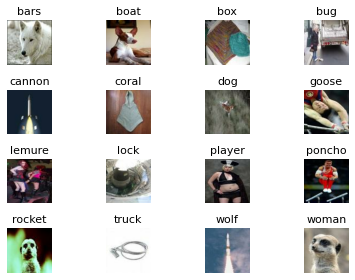

In [26]:
fc_model = build_fc_model()
"""
fc_history = fc_model.fit(
    train_set, steps_per_epoch=len(train_set)//batch_size, 
    epochs=epochs, validation_data=val_set)
    # callbacks=[best_chpt])
"""
fc_history = fc_model.fit_generator(
    train_gen, epochs=epochs, validation_data=val_gen,
    steps_per_epoch=len(train_gen)//batch_size)
# I might get back to checkpointing but for now it seems as a waste of time
preds = fc_model.predict(test_set)
#preds = np.argmax(probs, axis=1)
classes = train_set.class_names
#classes = [classes[x] for x in preds]
show_sample(test_set)
fc_model.save_weights('fc_model_weights.h5')

Epoch 1/10
1/1 [==============================] - 1s 930ms/step - loss: 2.7825 - categorical_accuracy: 0.0938 - recall_4: 0.0000e+00 - precision_4: 0.0000e+00 - val_loss: 2.7719 - val_categorical_accuracy: 0.0625 - val_recall_4: 0.0000e+00 - val_precision_4: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 1s 514ms/step - loss: 2.7853 - categorical_accuracy: 0.0625 - recall_4: 0.0000e+00 - precision_4: 0.0000e+00 - val_loss: 2.7740 - val_categorical_accuracy: 0.0625 - val_recall_4: 0.0000e+00 - val_precision_4: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 1s 518ms/step - loss: 2.7713 - categorical_accuracy: 0.0938 - recall_4: 0.0000e+00 - precision_4: 0.0000e+00 - val_loss: 2.7774 - val_categorical_accuracy: 0.0625 - val_recall_4: 0.0000e+00 - val_precision_4: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 1s 617ms/step - loss: 2.8000 - categorical_accuracy: 0.0000e+00 - recall_4: 0.0000e+00 - precision_4: 0.0000e+00 - val_loss: 2.7761 - val_ca

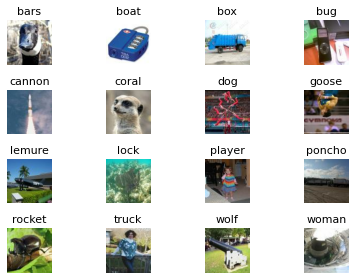

In [27]:
cnn_model = build_cnn_model()
"""
fc_history = fc_model.fit(
    train_set, steps_per_epoch=len(train_set)//batch_size, 
    epochs=epochs, validation_data=val_set)
    # callbacks=[best_chpt])
"""
cnn_history = cnn_model.fit_generator(
    train_gen, epochs=epochs, validation_data=val_gen,
    steps_per_epoch=len(train_gen)//batch_size)
# I might get back to checkpointing but for now it seems as a waste of time
probs = cnn_model.predict(test_set)
#preds = np.argmax(probs, axis=1)
classes = train_set.class_names
#classes = [classes[x] for x in preds]
show_sample(test_set)
cnn_model.save_weights('cnn_model_weights.h5')

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 3.5727 - categorical_accuracy: 0.0000e+00 - recall_5: 0.0000e+00 - precision_5: 0.0000e+00 - val_loss: 3.4550 - val_categorical_accuracy: 0.0667 - val_recall_5: 0.0000e+00 - val_precision_5: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 1s 720ms/step - loss: 19.8640 - categorical_accuracy: 0.0312 - recall_5: 0.0000e+00 - precision_5: 0.0000e+00 - val_loss: 4.1932 - val_categorical_accuracy: 0.0667 - val_recall_5: 0.0042 - val_precision_5: 0.3333
Epoch 3/10
1/1 [==============================] - 1s 718ms/step - loss: 20.1119 - categorical_accuracy: 0.0625 - recall_5: 0.0625 - precision_5: 0.0625 - val_loss: 3.9164 - val_categorical_accuracy: 0.0917 - val_recall_5: 0.0125 - val_precision_5: 0.1429
Epoch 4/10
1/1 [==============================] - 1s 727ms/step - loss: 21.6678 - categorical_accuracy: 0.0938 - recall_5: 0.0938 - precision_5: 0.1154 - val_loss: 3.3368 - val_categorical_accuracy: 0.0583 - val

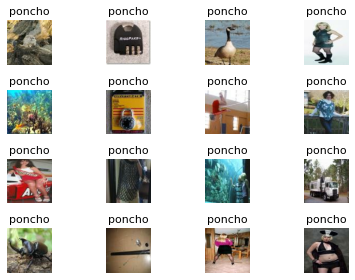

In [28]:
mini_resnet = build_resnet_model()
"""
fc_history = fc_model.fit(
    train_set, steps_per_epoch=len(train_set)//batch_size, 
    epochs=epochs, validation_data=val_set)
    # callbacks=[best_chpt])
"""
res_history = mini_resnet.fit_generator(
    train_gen, epochs=epochs, validation_data=val_gen,
    steps_per_epoch=len(train_gen)//batch_size)
# I might get back to checkpointing but for now it seems as a waste of time
preds = mini_resnet.predict(test_set)
#preds = np.argmax(probs, axis=1)
classes = train_set.class_names
#classes = [classes[x] for x in preds]
show_sample(test_set)
mini_resnet.save_weights('res_model_weights.h5')

Questions remaining unanswered yet:
* How model checkpoint callback of keras actually works? Trying to use one of this callbacks just causes overflow of memory.
* How to properly modularize repitative blocks and use them afterward?
* What is going on with CE loss with default keras 'categorical crossentropy'?
* How long would it take to compile TF for my local machine? Inprecise answer - at least 3 days (after that I lost my patience)

While I implimented many optimizations in pytorch, my knowledge of Tensorflow is limited. 